# Analysis

Import data and conduct experiments to answer questions about ALL/AML correlation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from utils import *

In [3]:
%%time
corr_df = load_tsv('/data/archive/compendium/v5/v5_all_by_all.2018-02-04.tsv')
meta_df = load_tsv('/data/archive/compendium/v5/clinical.tsv')
prep_df = load_tsv('~/work/TURG/resources/TreehouseCompendiumSamples_LibraryPrep.tsv')
type_df = pd.read_csv('~/work/TURG/resources/DiseaseAnnotations_2018-04_Labels.csv', sep=',', index_col=1)

CPU times: user 1min 43s, sys: 30 s, total: 2min 13s
Wall time: 2min 13s


In [4]:
sample_A = 'TH01_0121_S01'
sample_B = 'TH01_0123_S01'

### For each, what fraction of top 95% (corr > 0.87) were AML?

In [5]:
def print_distrib(sample_id):
    disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df)
    print('Sample ID:', sample_id)
    print('Disease distribution among samples with correlation > 0.87:')
    print(disease_distrib)

In [6]:
print_distrib(sample_A)
print()
print_distrib(sample_B)

Sample ID: TH01_0121_S01
Disease distribution among samples with correlation > 0.87:
acute myeloid leukemia              0.743590
acute leukemia                      0.102564
acute lymphoblastic leukemia        0.102564
juvenile myelomonocytic leukemia    0.051282
Name: Diagnosis/Disease, dtype: float64

Sample ID: TH01_0123_S01
Disease distribution among samples with correlation > 0.87:
acute myeloid leukemia          0.590476
acute lymphoblastic leukemia    0.380952
acute leukemia                  0.028571
Name: Diagnosis/Disease, dtype: float64


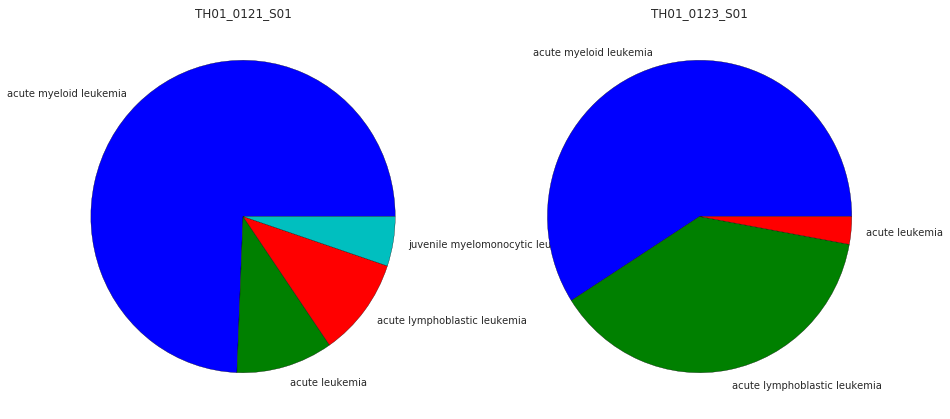

In [7]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
disease_distrib = diseases_correlated_above_threshold(sample_A, corr_df, type_df)
plt.title(sample_A)
plt.pie(disease_distrib, labels=disease_distrib.index)

plt.subplot(122)
disease_distrib = diseases_correlated_above_threshold(sample_B, corr_df, type_df)
plt.title(sample_B)
plt.pie(disease_distrib, labels=disease_distrib.index)

plt.show()

### How correlated are other ALL samples with AML?

Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [8]:
%%time
samples_with_ALL = get_samples_by_disease(ALL, type_df, meta_df)
fracs_aml = pd.Series()
sources = pd.Series()
prep_types = pd.Series()
for sample_id in samples_with_ALL:
    
    disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df)
    if disease_distrib is not None:
        fracs_aml[sample_id] = disease_distrib[AML] if AML in disease_distrib else 0.0
    
    source = sample_to_source(sample_id)
    sources[sample_id] = source
    
    sample_prep = prep_df.loc[sample_id]['libSelType']
    if type(sample_prep) == pd.Series:
        sample_prep = sample_prep.iloc[0]
    prep_types[sample_id] = sample_prep

Number of donors missing from file structure: 150
CPU times: user 5.19 s, sys: 244 ms, total: 5.44 s
Wall time: 5.43 s


In [9]:
samples_df = pd.DataFrame({'frac_AML': fracs_aml, 'source': sources, 'prep_type': prep_types})
samples_df.index.name = 'THid'
samples_df = samples_df[pd.notnull(samples_df['frac_AML'])]

In [67]:
def plot_criterion(df, criterion=None, title=None, range=(0, 1), color='blue', alpha=1.0, label=''):
    src_df = df if criterion is None else df.loc[criterion]
    plt.hist(src_df['frac_AML'], bins=30, range=range, color=color, alpha=alpha, label=label)
    if title is not None:
        plt.title(title)
    plt.xlabel('Frac AML')
    plt.ylabel('Freq')

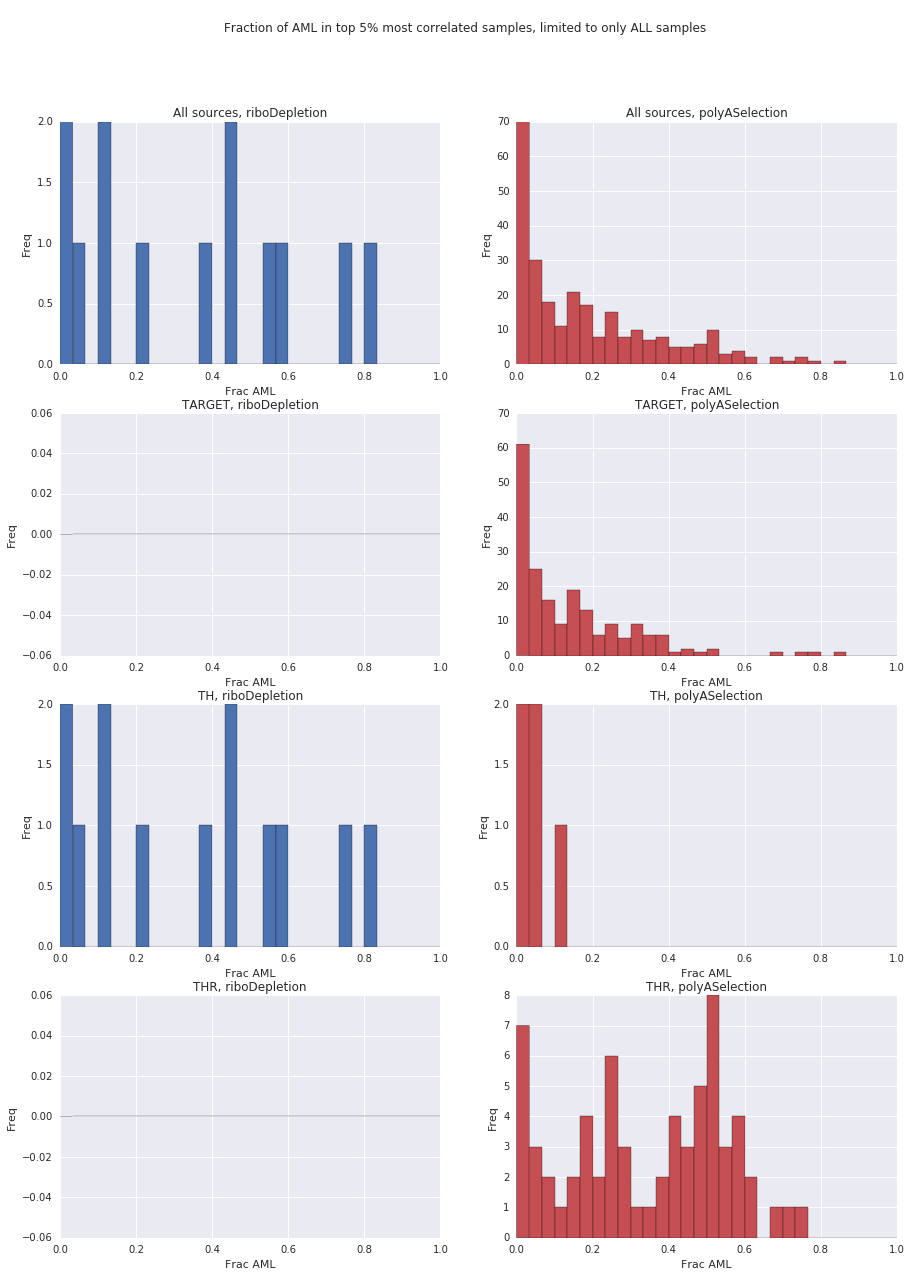

In [11]:
plt.figure(figsize=(15, 20))
suptitle = """
Fraction of AML in top 5% most correlated samples, limited to only ALL samples
"""
plt.suptitle(suptitle)

palette = sb.color_palette(n_colors=10)
color_1 = palette[0]
color_2 = palette[2]

plt.subplot(421)
criterion = samples_df['prep_type'] == 'riboDepletion'
plot_criterion(samples_df, criterion, title='All sources, riboDepletion', color=color_1)

plt.subplot(422)
criterion = samples_df['prep_type'] == 'polyASelection'
plot_criterion(samples_df, criterion, title='All sources, polyASelection', color=color_2)

plt.subplot(423)
criterion = (samples_df['source'] == 'TARGET') & (samples_df['prep_type'] == 'riboDepletion')
plot_criterion(samples_df, criterion, title='TARGET, riboDepletion', color=color_1)

plt.subplot(424)
criterion = (samples_df['source'] == 'TARGET') & (samples_df['prep_type'] == 'polyASelection')
plot_criterion(samples_df, criterion, title='TARGET, polyASelection', color=color_2)

plt.subplot(425)
criterion = (samples_df['source'] == 'TH') & (samples_df['prep_type'] == 'riboDepletion')
plot_criterion(samples_df, criterion, title='TH, riboDepletion', color=color_1)

plt.subplot(426)
criterion = (samples_df['source'] == 'TH') & (samples_df['prep_type'] == 'polyASelection')
plot_criterion(samples_df, criterion, title='TH, polyASelection', color=color_2)

plt.subplot(427)
criterion = (samples_df['source'] == 'THR') & (samples_df['prep_type'] == 'riboDepletion')
plot_criterion(samples_df, criterion, title='THR, riboDepletion', color=color_1)

plt.subplot(428)
criterion = (samples_df['source'] == 'THR') & (samples_df['prep_type'] == 'polyASelection')
plot_criterion(samples_df, criterion, title='THR, polyASelection', color=color_2)

plt.show()

In [48]:
sub_sources = pd.Series()
for sample in samples_with_ALL:
    m = re.search(r'[0-9][0-9]', sample)
    sub_src = sample[m.start():m.end()]
    sub_sources[sample] = sub_src
samples_df['sub_source'] = sub_sources

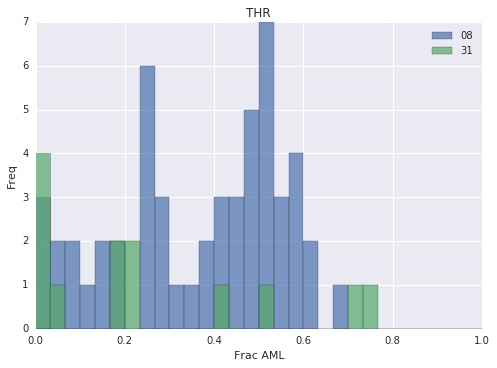

In [68]:
src_constraint = samples_df['source'] == 'THR'
sub_srcs = samples_df.loc[src_constraint]['sub_source'].unique()
constraints = {sub_src: (src_constraint & (samples_df['sub_source'] == sub_src)) for sub_src in sub_srcs}

for i, (subsrc, constraint) in enumerate(constraints.items()):
    plot_criterion(samples_df, constraint, title='THR', color=palette[i], alpha=0.7, label=subsrc)
    plt.legend(loc='upper right')
plt.show()

### Find the samples of any type that are most correlated with AML.

In [12]:
%%time
threshold = 0.3
fracs_aml = pd.Series()
diseases = pd.Series()
for sample_id in corr_df.index:
    disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df)
    frac_aml = disease_distrib[AML] if AML in disease_distrib else 0
    if frac_aml > threshold:
        fracs_aml[sample_id] = frac_aml
        donor_id = sample_to_donor(sample_id)
        disease = type_df.loc[donor_id]['Diagnosis/Disease']
        diseases[sample_id] = disease

CPU times: user 2min 42s, sys: 0 ns, total: 2min 42s
Wall time: 2min 43s


In [13]:
amlish_df = pd.DataFrame({'frac_AML': fracs_aml, 'disease': diseases})
amlish_df.index.name = 'THid'

Distribution of diseases in highly correlated to AML samples:


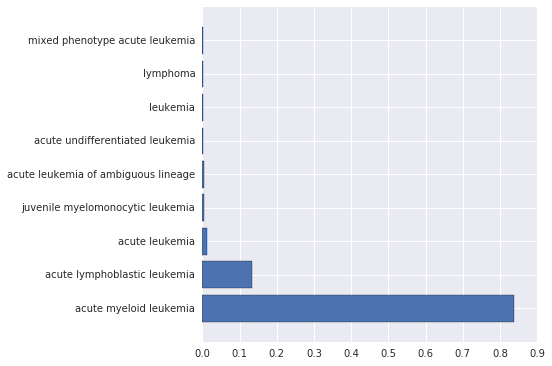

In [69]:
print('Distribution of diseases in highly correlated to AML samples:')
disease_distrib = amlish_df['disease'].value_counts() / len(amlish_df)

plt.figure(figsize=(6, 6))
plt.barh(range(len(disease_distrib)), disease_distrib, align='center')
plt.yticks(range(len(disease_distrib)), disease_distrib.index)
# plt.pie(disease_distrib, labels=disease_distrib.index)
plt.show()

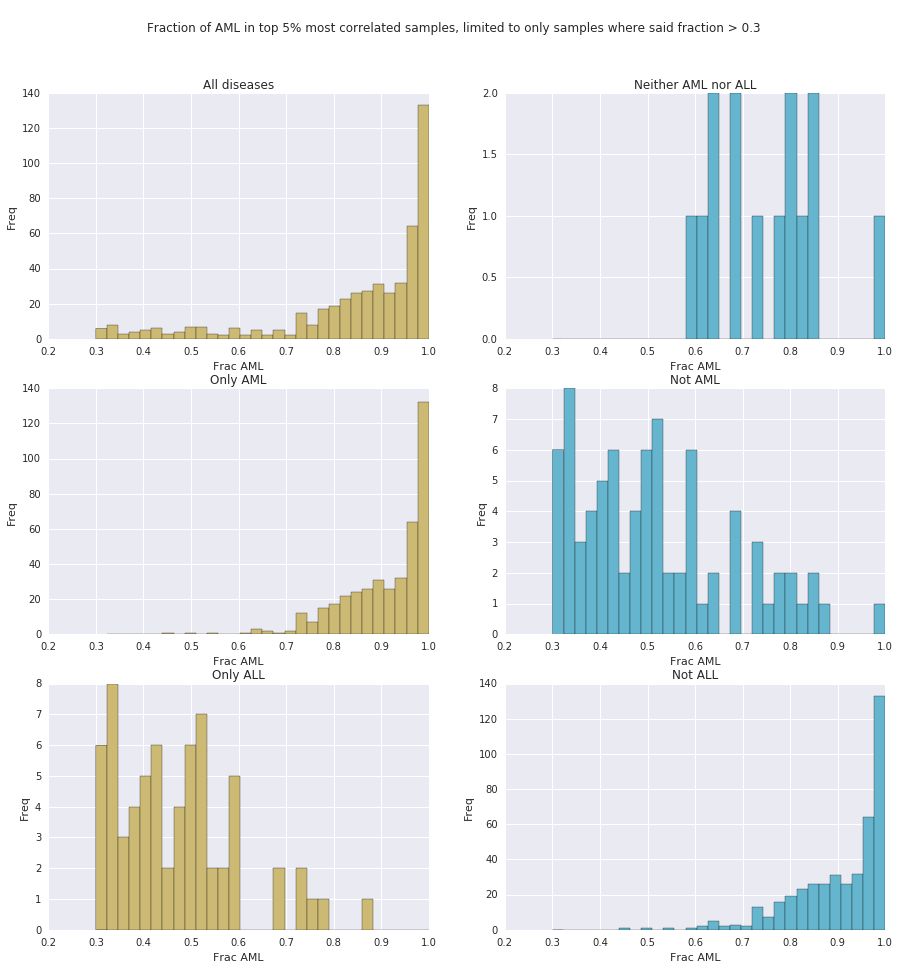

In [34]:
plt.figure(figsize=(15, 15))
suptitle = """
Fraction of AML in top 5% most correlated samples, limited to only samples where said fraction > 0.3
"""
plt.suptitle(suptitle)

palette = sb.color_palette(n_colors=10)
color_1 = palette[4]
color_2 = palette[5]

not_AML = amlish_df['disease'] != AML
not_ALL = amlish_df['disease'] != ALL

plt.subplot(321)
plot_criterion(amlish_df, title='All diseases', range=(0.3, 1), color=color_1)

plt.subplot(322)
plot_criterion(amlish_df, not_AML & not_ALL, title='Neither AML nor ALL', range=(0.3, 1), color=color_2)

plt.subplot(323)
plot_criterion(amlish_df, ~not_AML, title='Only AML', range=(0.3, 1), color=color_1)

plt.subplot(324)
plot_criterion(amlish_df, not_AML, title='Not AML', range=(0.3, 1), color=color_2)

plt.subplot(325)
plot_criterion(amlish_df, ~not_ALL, title='Only ALL', range=(0.3, 1), color=color_1)

plt.subplot(326)
plot_criterion(amlish_df, not_ALL, title='Not ALL', range=(0.3, 1), color=color_2)

plt.show()